In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils.data
import utils.spectral
from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

In [1]:
fps = ['./SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl']

In [4]:
df_b = pd.read_pickle(fps[0])
# df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

FileNotFoundError: [Errno 2] No such file or directory: './SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl'

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius','q_NEC_CRF']]
# df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
# df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values, df_b_IGRF_clip.index.values))

True

In [6]:
ehx = df_e_clip['Ehx'].values

In [7]:
from pyaw.core.preprocess_data import SwarmPreprocess

b_nec2sc = SwarmPreprocess.MagPreprocess.NEC2SC(df_b_clip['B_NEC'].values,df_b_clip['q_NEC_CRF'].values)
b_sc = b_nec2sc.calculate_rotated_vectors()

b_igrf_nec2sc = SwarmPreprocess.MagPreprocess.NEC2SC(df_b_IGRF_clip['B_NEC_IGRF'].values,df_b_clip['q_NEC_CRF'].values)
b_igrf_sc = b_igrf_nec2sc.calculate_rotated_vectors()

by1 = b_sc[:,1] - b_igrf_sc[:,1]

In [8]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.data.align_high2low(by1, datetimes_b, datetimes_e)

# dynamic: 06:47:35-06:48:55

In [ ]:
import pywt

fs=16
wavelet = 'cmor1.5-1.0'
num_frequencies = 160
min_freq, max_freq = 1e-3, 16  # Desired frequency range

# Compute uniformly spaced frequencies
freqs = np.linspace(min_freq, max_freq, num_frequencies)

# Compute corresponding scales
central_freq = pywt.central_frequency(wavelet)

scales = central_freq / (freqs * (1 / fs))

In [23]:
st_dy = np.datetime64('2016-03-11T06:47:35')
et_dy = np.datetime64('2016-03-11T06:47:55')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [24]:
cwt_eb_dy = utils.spectral.CWT(ehx_dy, by1_dy, scales=scales, fs=fs)
cwt_eb_m_dy, cwt_eb_p_dy, cwt_eb_f_dy = cwt_eb_dy.get_cross_spectral()

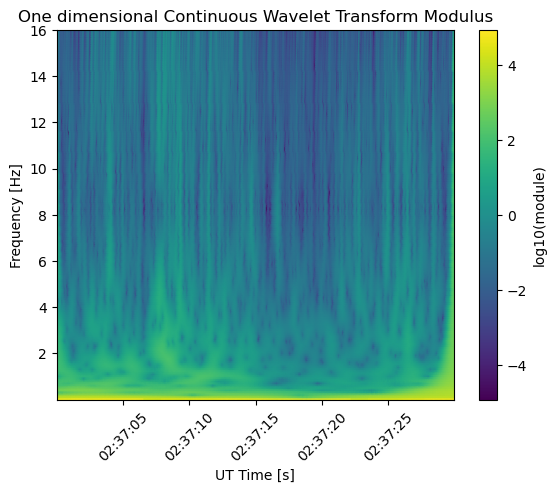

In [25]:
plt.pcolormesh(datetimes_dy,cwt_eb_f_dy,np.log10(cwt_eb_m_dy),shading='gouraud')
plt.colorbar(label='log10(module)')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

In [26]:
num_bins=50
cwt_eb_p_bins_dy, cwt_eb_p_histogram2d_dy = utils.get_phase_histogram2d(cwt_eb_f_dy, cwt_eb_p_dy, num_bins)

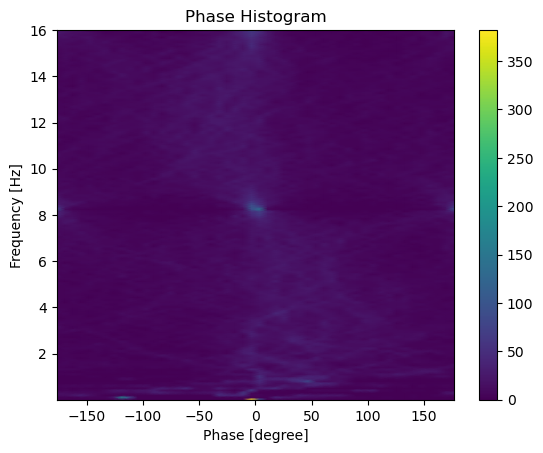

In [27]:
plt.pcolormesh((cwt_eb_p_bins_dy[:-1] + cwt_eb_p_bins_dy[1:]) / 2, cwt_eb_f_dy, cwt_eb_p_histogram2d_dy, shading='gouraud')
plt.colorbar()
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()

In [28]:
cwt_p_ave_dy = utils.get_phase_histogram_f_ave(cwt_eb_p_bins_dy,cwt_eb_p_histogram2d_dy)

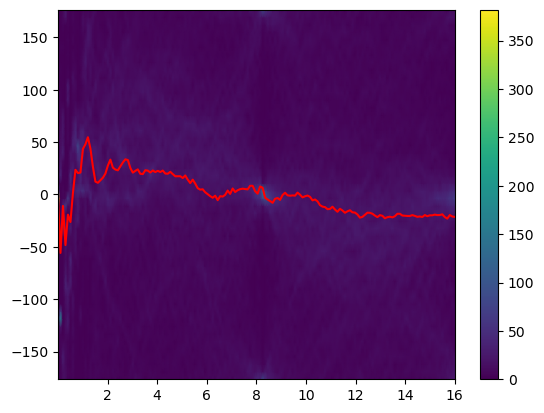

In [29]:
plt.pcolormesh(cwt_eb_f_dy, (cwt_eb_p_bins_dy[:-1] + cwt_eb_p_bins_dy[1:]) / 2, cwt_eb_p_histogram2d_dy.T, shading='gouraud')
plt.plot(cwt_eb_f_dy,cwt_p_ave_dy,color='r')
plt.colorbar()
plt.show()

# static: 064705-064725

In [30]:
st_sta = np.datetime64('2016-03-11T06:47:05')
et_sta = np.datetime64('2016-03-11T06:47:25')
t_mask = (datetimes_e >= st_sta) & (datetimes_e <= et_sta)
datetimes_sta = datetimes_e[t_mask]
ehx_sta = ehx[t_mask]
by1_sta = by1[t_mask]

In [31]:
cwt_eb_sta = utils.spectral.CWT(ehx_sta, by1_sta, scales=scales, fs=fs)
cwt_eb_m_sta, cwt_eb_p_sta, cwt_eb_f_sta = cwt_eb_sta.get_cross_spectral()

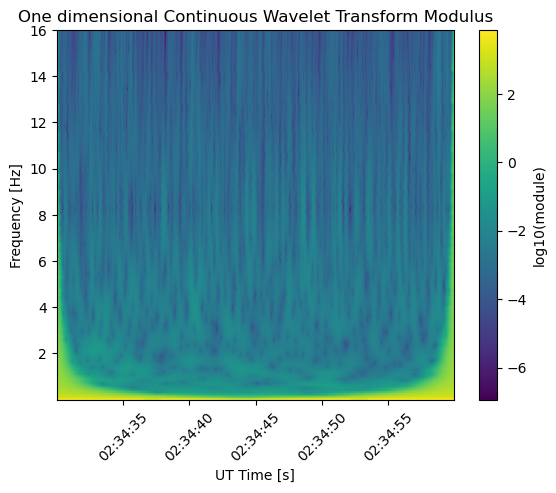

In [32]:
plt.pcolormesh(datetimes_sta,cwt_eb_f_sta,np.log10(cwt_eb_m_sta),shading='gouraud')
plt.colorbar(label='log10(module)')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

In [33]:
cwt_eb_p_bins_sta, cwt_eb_p_histogram2d_sta = utils.get_phase_histogram2d(cwt_eb_f_sta, cwt_eb_p_sta, num_bins)

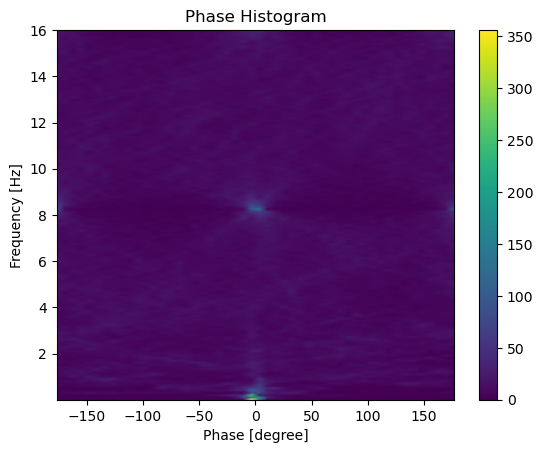

In [34]:
plt.pcolormesh((cwt_eb_p_bins_sta[:-1] + cwt_eb_p_bins_sta[1:]) / 2, cwt_eb_f_sta, cwt_eb_p_histogram2d_sta, shading='gouraud')
plt.colorbar()
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()  # cwt是否也能格局模设置阈值对相位进行筛选？

In [35]:
cwt_p_ave_sta = utils.get_phase_histogram_f_ave(cwt_eb_p_bins_sta,cwt_eb_p_histogram2d_sta)

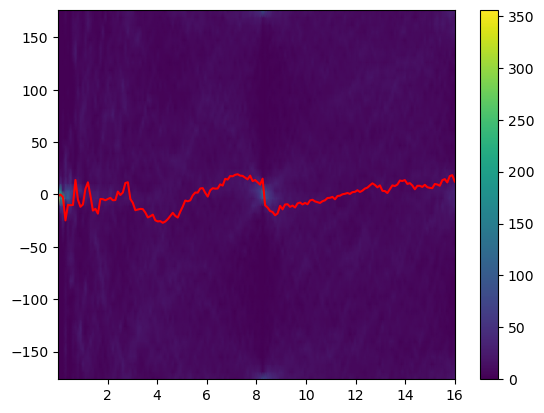

In [36]:
plt.pcolormesh(cwt_eb_f_sta, (cwt_eb_p_bins_sta[:-1] + cwt_eb_p_bins_sta[1:]) / 2, cwt_eb_p_histogram2d_sta.T, shading='gouraud')
plt.plot(cwt_eb_f_sta,cwt_p_ave_sta,color='r')
plt.colorbar()
plt.show()